# Uso del aprendizaje supervisado, con t-SNE y modelos jerarquicos
Gabriel Suarez

A continuación se presenta un estudio de aprendizaje supervisado, el cual esta basado en predicir si un tumor es maligno o benigno según 32 caracteristicas. Cada caracteristica representa un valor de media, error estandar y peor valor. Se utilizan un metodo de reducción de dimensionalidad (t-SNE), para luego aplicar modelos de clasificación jerarquicos y no jerarquicos.

## Importando librerias

In [995]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

## Cargando datos

Caragamos nuestro Dataset mediante la libreria Pandas, obtendremos un Dataframe listo para trabajar. Despues de esto procedemos a obtener una vista previa de nuestro Dataset

In [996]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Ahora bien, una vez ya tenemos una vista inicial del Dataset, procedemos a tener una vista profunda del Dataset, miraremos la cantidad de datos no nulos y el tipo de datos que tenemos en cada columna.

In [997]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Eliminamos las columnas que no nos aportan informacion relevante para nuestro analisis, en este caso eliminamos la columna "Unnamed: 32" y "id" ya que no nos aportan informacion relevante para nuestro analisis.

In [998]:
df.drop(['id'], axis=1, inplace=True)
df.drop(['Unnamed: 32'], axis=1, inplace=True)

Mapeamos los datos de la columna "diagnosis" a valores numericos, en este caso "M" = 1 y "B" = 0

Recordemos que la variable "diagnosis" es la variable que queremos predecir, por lo tanto es nuestra variable objetivo.

In [999]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})

## Explorando datos

Una vez eliminado las anteriores variables y obviando la variable target, contamos con 30 variables, de estas 30 variables 10 son caracteristicas de media, 10 son caracteristicas de error estandar y 10 son caracteristicas de peor valor. Por esa razón, decidimos separar las variables en 3 grupos, y solo trabajar con la media de las caracteristicas.

In [1000]:
df = df.iloc[:, 0:11]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    int64  
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 49.0 KB


Preparamos nuestro Dataset para ser visualizado en un grafico de correlación

In [1001]:
df_corr = df.copy()
df_corr.drop(['diagnosis'], axis=1, inplace=True)

Graficamos la matriz de correlación de las variables, para ver si existe alguna correlación entre las variables, y si existe alguna variable que no aporte información relevante para nuestro analisis.

<Axes: >

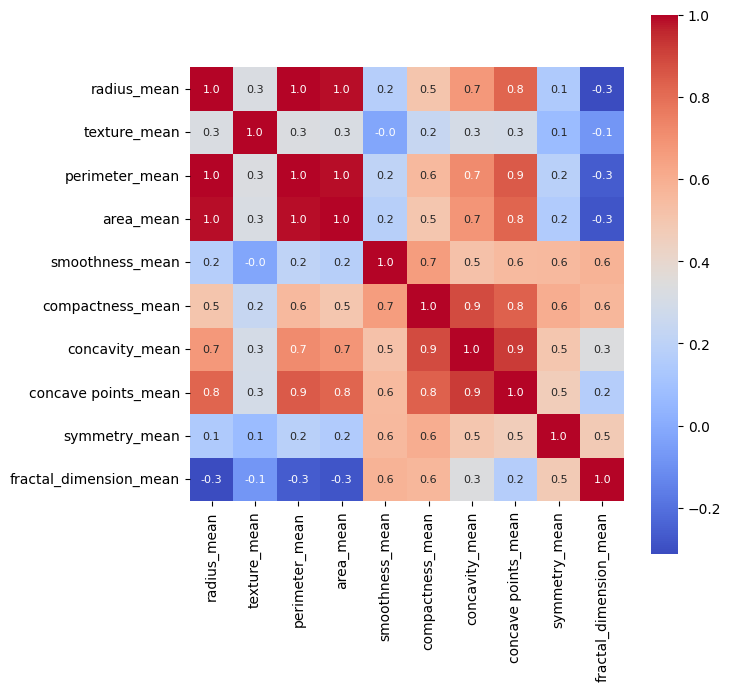

In [1002]:
corr = df_corr.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.1f',annot_kws={'size': 8},
           xticklabels= df_corr.columns, yticklabels= df_corr.columns,
           cmap= 'coolwarm')

<b>Se puede observar lo siguiente</b>

* La variable radius, parameter y area estan altamente correlacionadas, por lo tanto solo usaremos la variable area_mean
* La variable compactness_mean, concavity_mean y concavepoint_mean estan altamente correlacionadas, por lo tanto solo usaremos la variable compactness_mean
* Ya por ultimo, utilizamos las variables sobrantes para seguir trabajando con nuestro analisis.

In [1003]:
df.drop(['concavity_mean', 'radius_mean', 'perimeter_mean', 'concave points_mean'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    int64  
 1   texture_mean            569 non-null    float64
 2   area_mean               569 non-null    float64
 3   smoothness_mean         569 non-null    float64
 4   compactness_mean        569 non-null    float64
 5   symmetry_mean           569 non-null    float64
 6   fractal_dimension_mean  569 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.2 KB


Dividimos nuestros datos en datos de prueba y entrenamiento, recordemos que debemos de sacar la variable target de nuestros datos, definir el porcentaje y además definir la semilla

In [1004]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["diagnosis"], axis=1), df["diagnosis"], test_size=0.2, random_state=42)

Normalizamos los datos para poder realizar el analisis de dimensionalidad con t-SNE

In [1005]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Debido a que nuestro Dataset tiene 7 columnas, es dificil tener una vista previa de los datos, por lo tanto procedemos a utilizar un metodo de reduccion de dimensionalidad llamado t-SNE, el cual nos permite reducir la dimensionalidad de nuestro Dataset a 2 dimensiones, de esta manera podemos tener una vista previa de nuestros datos.

C:\Users\Gabriel Suarez\AppData\Local\Temp\ipykernel_7980\1226062771.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.cm.get_cmap("viridis", 2))


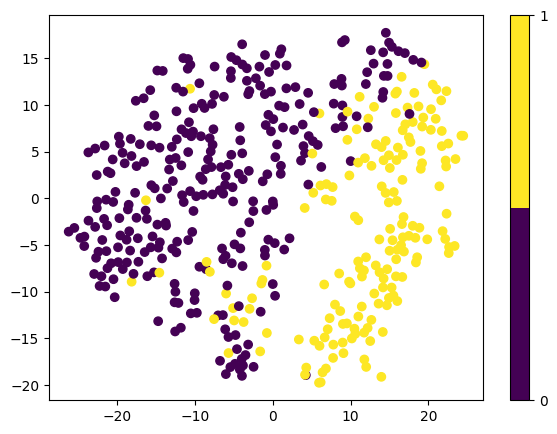

In [1006]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.cm.get_cmap("viridis", 2))
plt.colorbar(ticks=[0, 1])
plt.show()

Una vez determinado que nuestro Dataset es linealmente separable, procedemos a ver cuales son las variables más importantes de nuestra data, utilizamos un Random Forest para determinar cuales son las variables más importantes, y las visualizamos mediante un grafico de barras.

## Feature Engineering

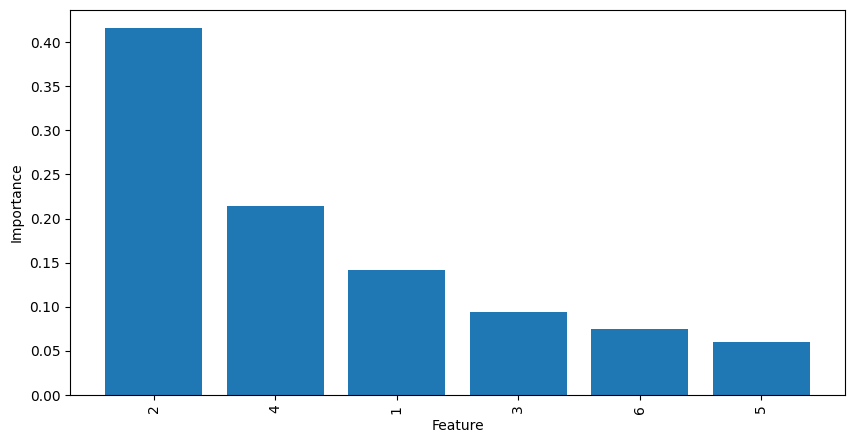

In [1007]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), indices+1, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Ahora procedemos a ver la importancia acumulada por cada variable, se puede observar que con dos variables ya obtenemos más de un 60% de representación de los datos

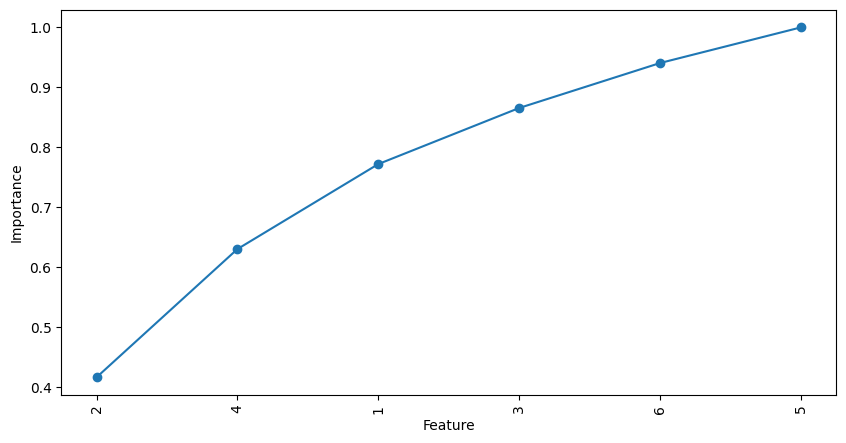

In [1008]:
cumulative_importance = np.cumsum(importances[indices])

plt.figure(figsize=(10,5))
plt.plot(range(X_train.shape[1]), cumulative_importance, marker='o')
plt.xticks(range(X_train.shape[1]), indices+1, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Aplicamos varios modelos de aprendizaje supervisado para saber cual de todos es el mejor para nuestro analisis, para esto utilizamos los siguientes modelos:

In [1009]:
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
adab = AdaBoostClassifier(n_estimators=100, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier()
bag = BaggingClassifier(n_estimators=100, random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)
lr = LogisticRegression(random_state=42)
gradb = GradientBoostingClassifier(n_estimators=100, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
nb = GaussianNB()
sgd = SGDClassifier(random_state=42)

Entrenamos los modelos, lo hacemos con validación cruzada dividiendo el dataset en 3 partes, esto se hace con la finalad de obtener un mejor resultado y evitar un overfitting en los resultados

In [1010]:
et_scores = cross_val_score(et, X_train, y_train, cv=3, scoring='accuracy')
adab_scores = cross_val_score(adab, X_train, y_train, cv=3, scoring='accuracy')
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy')
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=3, scoring='accuracy')
knn_scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
bag_scores = cross_val_score(bag, X_train, y_train, cv=3, scoring='accuracy')
nn_scores = cross_val_score(nn, X_train, y_train, cv=3, scoring='accuracy')
lr_scores = cross_val_score(lr, X_train, y_train, cv=3, scoring='accuracy')
gradb_scores = cross_val_score(gradb, X_train, y_train, cv=3, scoring='accuracy')
dt_scores = cross_val_score(dt, X_train, y_train, cv=3, scoring='accuracy')
nb_scores = cross_val_score(nb, X_train, y_train, cv=3, scoring='accuracy')
sgd_scores = cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

Seleccionamos la media obtenida en cada modelo y la comparamos con la media de los modelos, para saber cual es el mejor modelo para nuestro analisis

In [1011]:
et_acc = et_scores.mean()
adab_acc = adab_scores.mean()
rf_acc = rf_scores.mean()
xgb_acc = xgb_scores.mean()
knn_acc = knn_scores.mean()
bag_acc = bag_scores.mean()
nn_acc = nn_scores.mean()
lr_acc = lr_scores.mean()
gradb_acc = gradb_scores.mean()
dt_acc = dt_scores.mean()
nb_acc = nb_scores.mean()
sgd_acc = sgd_scores.mean()

Preparamos nuestros arrays para poder graficar los resultados obtenidos

In [1012]:
model_names = ['ET', 'Adab', 'RF', 'XgB', 'KNN', 'Bag', 'NN', 'LR', 'GradB', 'DT', 'NB', 'SGD']
accuracies = [et_acc, adab_acc, rf_acc, xgb_acc, knn_acc, bag_acc, nn_acc, lr_acc, gradb_acc, dt_acc, nb_acc, sgd_acc]

Graficamos cada modelo para poder compararlos y saber cual es el mejor modelo para nuestro analisis

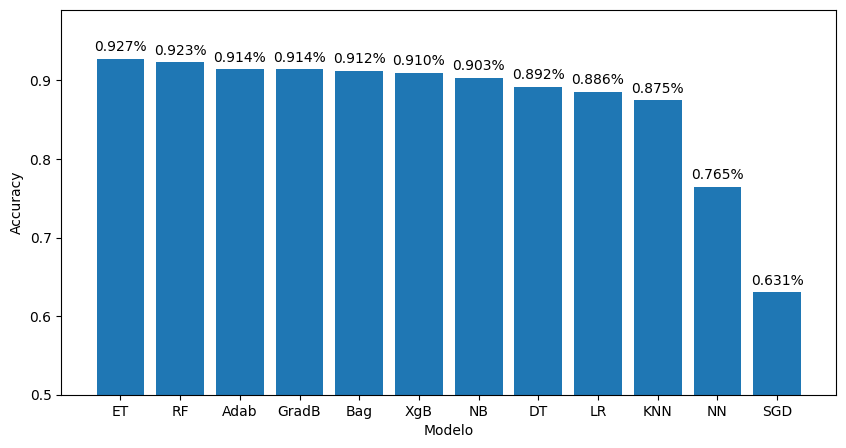

In [1013]:
import operator

model_accuracies = list(zip(model_names, accuracies))
model_accuracies_sorted = sorted(model_accuracies, key=operator.itemgetter(1), reverse=True)

plt.figure(figsize=(10,5))
plt.bar([x[0] for x in model_accuracies_sorted], [x[1] for x in model_accuracies_sorted])
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.99])

for i, acc in enumerate([x[1] for x in model_accuracies_sorted]):
    plt.text(i, acc+0.01, f'{acc:.3f}%', ha='center')

plt.show()


Ya sabemos que los mejores algoritmos para este problema son los algoritmos ET, RF, Adab, GradB

### Modelos Jerarquicos

Una vez ya tenemos el resultado del accuracy de cada modelo por separado, procedemos a crear modelos jerarquicos para mejorar nuestros modelos, para esto utilizamos los siguientes modelos, obtendremos los modelos ensamblados mediante voto y promedio de peso. Empezaremos por peso

In [1014]:
model1 = AdaBoostClassifier(n_estimators=100, random_state=42)
model2 = BaggingClassifier(n_estimators=100, random_state=42)
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model4 = ExtraTreesClassifier(n_estimators=100, random_state=42)


preds_model1 = cross_val_predict(model1, X_train, y_train, cv=3, method='predict_proba')
preds_model2 = cross_val_predict(model2, X_train, y_train, cv=3, method='predict_proba')
preds_model3 = cross_val_predict(model3, X_train, y_train, cv=3, method='predict_proba')
preds_model4 = cross_val_predict(model4, X_train, y_train, cv=3, method='predict_proba')


# Tomar el promedio de las predicciones de cada modelo
preds_avg = (preds_model1 + preds_model2 + preds_model3 + preds_model4) / 4

# Convertir el promedio en una predicción final
final_preds = np.argmax(preds_avg, axis=1)

# Calcular la precisión del modelo ensamblado
accuracy = np.mean(final_preds == y_train)

print("Predicciones del modelo 1:", accuracies[2])
print("Precisión del modelo ensamblado:", accuracy)

Predicciones del modelo 1: 0.922998721970489
Precisión del modelo ensamblado: 0.9274725274725275


Podemos observar que el accuracy de los modelos ensamblados mediante promedio de peso es mejor que los modelos por separado, sin embargo esta mejora es muy minima. Ahora procederemos con la ensamblacion mediante voto

In [1015]:
model1 = AdaBoostClassifier(n_estimators=100, random_state=42)
model2 = BaggingClassifier(n_estimators=100, random_state=42)
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model4 = ExtraTreesClassifier(n_estimators=100, random_state=42)

ensemble_model = VotingClassifier(estimators=[('AdaB', model1), ('Bag', model2), ('RF', model3), ('EX', model4)], voting='hard')

ensemble_model.fit(X_train, y_train)

accuracy = ensemble_model.score(X_test, y_test)

print("Precisión del modelo de ensamblado por votos:", accuracy)

Precisión del modelo de ensamblado por votos: 0.9473684210526315


Ahora el modelo crecio casí en un 2%, por lo tanto podemos decir que el mejor modelo para nuestro analisis es el modelo ensamblado mediante voto.

Con este modelo final, procedemos a gráficar la matriz de confusión para tener la comparación de los resultados obtenidos

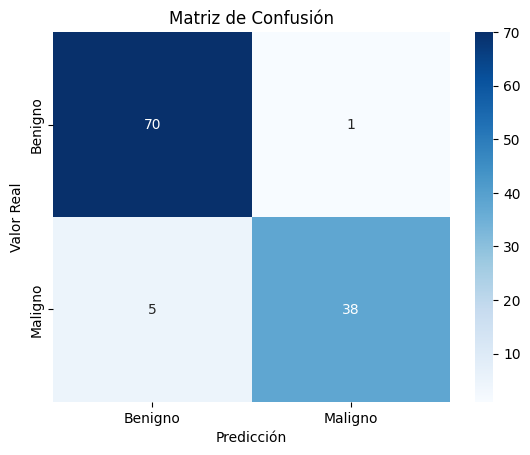

In [1016]:
y_pred = ensemble_model.predict(X_test)

# Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear heatmap con Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()